## **Initial configuration**

In [ ]:
import os
import tqdm
import time

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

!pip install -q tf-models-official
!pip install -q -U tensorflow-text 
!pip install -U spacy
!python -m spacy download en_core_web_md

import tensorflow_hub as hub
import tensorflow_text as text

import en_core_web_md
from google.colab import drive
drive.mount('/content/drive')
 
!cp /content/drive/MyDrive/HLT/dataset/* .

Mounted at /content/drive
cp: -r not specified; omitting directory '/content/drive/MyDrive/HLT/dataset/base_model'
cp: -r not specified; omitting directory '/content/drive/MyDrive/HLT/dataset/dataset_split'


In [ ]:
NUM_CLASSES=4

MODEL_DIR="/content/drive/MyDrive/HLT/"
DATA_DIR=MODEL_DIR+"dataset/dataset_split/"

BERT_MODEL="https://tfhub.dev/tensorflow/albert_en_base/3"
BERT_PREPROCESS_MODEL="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

BATCH_SIZE=32
LABELS=['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED=['unrelated','related']
RELATED=LABELS[0:3]
TARGET_COLUMN="Stance"

MAX_WORDS=20000     # max number of words in the dictionary
SEQ_LENGTH=128      # max sequence length of text 
EMBEDDING_DIM=300   # size of spacy embeddings

In [ ]:
# utility functions
def get_predictions(head, body, model_used):
  
  prediction = model_used.predict([head, body])

  pred_labels = prediction.argmax(axis=1)
  pred_labels = np.array([LABELS[i] for i in pred_labels])

  return pred_labels


def score_metrics(gold_labels, pred_labels):
  score = 0.0
  for i, (g, t) in enumerate(zip(gold_labels, pred_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

  return score


def get_vectorizer(seq_length):
  headline, articleBody, labels = get_dataset("train")
  concat = np.concatenate((headline, articleBody))

  vectorizer = layers.TextVectorization(max_tokens=MAX_WORDS, 
                                output_mode = 'int', 
                                standardize='lower_and_strip_punctuation',
                                split="whitespace",
                                ngrams=None, 
                                output_sequence_length=seq_length,
                                pad_to_max_tokens=True,)
  
  vectorizer.adapt(concat)

  return vectorizer


def play_with_vectorizer(vectorizer):
  voc = vectorizer.get_vocabulary()
  num_tokens = len(voc)
  print(f'Vocabulary size: {num_tokens}')
  print(f'Vocabulary beginning: {voc[:5]}')

  example = "the pen is on the table"
  vectorized_example = vectorizer([[example]])

  print(f'Example to give as input to the vectorizer: "{example}"')
  print(f'Size of vectorized example: {vectorized_example.numpy().shape}')
  print(f'Vector of the example: {vectorized_example.numpy()[0]}')


def get_embedding_matrix(vectorizer, embedding_dim):
  voc = vectorizer.get_vocabulary()
  num_tokens = len(voc)
  word_index = dict(zip(voc, range(num_tokens)))   # buiilding a dictionary with a (key, value)=(word, position in voc) for each word in the vocabulary

  nlp = en_core_web_md.load()   # loading pretrained embedding with spacy
           
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))  #  embedding_dim is the spacy dimensionality of embeddings

  for word, i in tqdm.tqdm(word_index.items()):
      embedding_vector = nlp(str(word)).vector
      if np.linalg.norm(embedding_vector)!=0:     # Words not found in embedding index will be all-zeros, so their norm would be zero. 
          embedding_matrix[i] = embedding_vector  # This includes the representation for "padding" and "OOV" i.e. Out Of Vocabulary
          hits += 1                               
      else:
          misses += 1
  print()
  print("Converted %d words (%d misses)" % (hits, misses))

  return embedding_matrix


def get_dataset(dataset):
  data_bodies = pd.read_csv(dataset + "_bodies.csv")
  data_stances = pd.read_csv(dataset + "_stances.csv")

  join_data =  pd.merge(data_stances, data_bodies, how="inner", on=["Body ID"])
  join_data = join_data[['Body ID', 'Headline', 'articleBody', 'Stance']]

  join_data[TARGET_COLUMN] = join_data[TARGET_COLUMN].astype('category')

  headline = join_data.Headline.map(str).to_numpy()  # headline -> str
  articleBody = join_data.articleBody.map(str).to_numpy()  # articleBody -> str


  labels = join_data[TARGET_COLUMN].cat.codes.to_numpy()  # integer labels of categories

  return headline, articleBody, labels


def save_dataset_splitted(sample_size=-1):
  data_bodies = pd.read_csv("train_bodies.csv")
  data_stances = pd.read_csv("train_stances.csv")

  join_data =  pd.merge(data_stances, data_bodies, how="inner", on=["Body ID"])
  join_data = join_data[['Body ID', 'Headline', 'articleBody', 'Stance']]

  join_data[TARGET_COLUMN] = join_data[TARGET_COLUMN].astype('category')

  if sample_size != -1:
    join_data = join_data[:sample_size]

  train_annot, val_annot = train_test_split(join_data, test_size=0.2, random_state=42, shuffle=True, stratify=join_data[TARGET_COLUMN])

  train_annot.to_csv(DATA_DIR + 'train_annot.csv')
  val_annot.to_csv(DATA_DIR + 'val_annot.csv')
  

def get_dataset_splitted():
  train_annot = pd.read_csv(DATA_DIR + "train_annot.csv")
  val_annot = pd.read_csv(DATA_DIR + "val_annot.csv")

  headline_train = train_annot.Headline.map(str).to_numpy()  # headline -> str
  headline_val = val_annot.Headline.map(str).to_numpy()  
  
  train_annot[TARGET_COLUMN] = train_annot[TARGET_COLUMN].astype('category')
  val_annot[TARGET_COLUMN] = val_annot[TARGET_COLUMN].astype('category')
  articleBody_train = train_annot.articleBody.map(str).to_numpy()  # articleBody -> str
  articleBody_val = val_annot.articleBody.map(str).to_numpy()  


  labels_train = train_annot[TARGET_COLUMN].cat.codes.to_numpy()  # integer labels of categories
  labels_val = val_annot[TARGET_COLUMN].cat.codes.to_numpy()

  return headline_train, articleBody_train, labels_train, headline_val, articleBody_val, labels_val


def get_confusion_matrix(gold_labels, pred_labels):  
    confusion_matrix = [[0, 0, 0, 0],   #this is the confusion_matrix
                        [0, 0, 0, 0],
                        [0, 0, 0, 0],
                        [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, pred_labels)):
        confusion_matrix[LABELS.index(g)][LABELS.index(t)] += 1

    return confusion_matrix


# monitoring metrics
def f1_training(y_true, y_pred):     
    """ Calculate the micro f1, so globally by counting the total true positives, false negatives and false positives.""" 
    precision = precision_training(y_true, y_pred)
    recall = recall_training(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def recall_training(y_true, y_pred):
    """ Calculate the recall, so globally by counting the total true positives, false negatives and false positives.""" 
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall


def precision_training(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

## **CNN base**

In [ ]:
vectorizer = get_vectorizer(SEQ_LENGTH)
play_with_vectorizer(vectorizer)

Vocabulary size: 20000
Vocabulary beginning: ['', '[UNK]', 'the', 'to', 'a']
Example to give as input to the vectorizer: "the pen is on the table"
Size of vectorized example: (1, 128)
Vector of the example: [   2    1    9   11    2 3038    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
embedding_matrix = get_embedding_matrix(vectorizer, EMBEDDING_DIM)

100%|██████████| 20000/20000 [01:44<00:00, 190.89it/s]


Converted 17713 words (2287 misses)


In [ ]:
#manipulate the dataset in input to the model
headline_train, body_train, labels_train, headline_val, body_val, labels_val = get_dataset_splitted()

vect_head_train = vectorizer(np.array([[s] for s in headline_train])).numpy()    # First create a numpy array of shape Nx1 with N = #texts, 
vect_head_val = vectorizer(np.array([[s] for s in headline_val])).numpy()        # then get a Tensor of shape NxSEQ_LENGTH that is the result of the vectorization
                                                                                 # of all text, truncated at SEQ_LENGTH and finally convert it into a numpy array

vect_body_train = vectorizer(np.array([[s] for s in body_train])).numpy()
vect_body_val = vectorizer(np.array([[s] for s in body_val])).numpy()

In [ ]:
# Build the model with the Functional API

# initialize an embedding layer that is just a matrix of size V x E
# where is done a lookup operation to take the word embedding of a word
embedding_layer = layers.Embedding(
    len(vectorizer.get_vocabulary()),
    EMBEDDING_DIM,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),                                                                                  
    trainable=False,                                                         
)

head_input = keras.Input(shape=(None,), dtype="int64", name="title")
body_input = keras.Input(shape=(None,), dtype="int64", name="body")

embedded_head = embedding_layer(head_input)
embedded_body = embedding_layer(body_input)

head = layers.Conv1D(256, 5, activation="relu", padding="same")(embedded_head)
head = layers.Dropout(0.5)(head)
head = layers.MaxPooling1D()(head)  # padding default to valid
head = layers.Conv1D(256, 5, activation="relu", padding="same")(head)
head = layers.Dropout(0.5)(head)
head = layers.MaxPooling1D()(head)
head = layers.Conv1D(512, 5, activation="relu", padding="same")(head)
head = layers.Dropout(0.5)(head)
head = layers.MaxPooling1D()(head)
head = layers.Conv1D(512, 5, activation="relu", padding="same")(head)
head = layers.Dropout(0.5)(head)
head = layers.Conv1D(768, 5, activation="relu", padding="same")(head)
head = layers.Dropout(0.5)(head)
head = layers.GlobalMaxPooling1D()(head)

body = layers.Conv1D(256, 5, activation="relu", padding="same")(embedded_body)
body = layers.Dropout(0.5)(body)
body = layers.MaxPooling1D()(body)
body = layers.Conv1D(256, 5, activation="relu", padding="same")(body)
body = layers.Dropout(0.5)(body)
body = layers.MaxPooling1D()(body)
body = layers.Conv1D(512, 5, activation="relu", padding="same")(body)
body = layers.Dropout(0.5)(body)
body = layers.MaxPooling1D()(body)
body = layers.Conv1D(512, 5, activation="relu", padding="same")(body)
body = layers.Dropout(0.5)(body)
body = layers.Conv1D(768, 5, activation="relu", padding="same")(body)
body = layers.Dropout(0.5)(body)
body = layers.GlobalMaxPooling1D()(body) 

concatted = tf.keras.layers.Concatenate()([head, body])

x = layers.Dense(1024, activation="relu")(concatted)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
preds = layers.Dense(NUM_CLASSES, activation="softmax", name='classifier')(x)

model = keras.Model([head_input, body_input], preds)
model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) #in fact labels are not one-hot encoded

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR + "/cnn_model/seq_length_5.h5",   
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

learning_rate = 2e-4
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

metrics = ['accuracy', 
          f1_training,
          recall_training,
          precision_training]

model.compile(
    loss=loss, 
    optimizer=optimizer, 
    metrics=metrics
)

In [ ]:
EPOCHS=20

model.fit({"title": vect_head_train, "body": vect_body_train},
          labels_train,  
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          validation_data=({"title": vect_head_val, "body": vect_body_val}, labels_val), 
          callbacks=[checkpoint, earlystopping],
          verbose=1
)

## **CNN with BERT embeddings**

In [ ]:
head_input = keras.Input(shape=(), dtype=tf.string, name="title")
body_input = keras.Input(shape=(), dtype=tf.string, name="body")

preprocessing_layer = hub.KerasLayer(BERT_PREPROCESS_MODEL, name='preprocessing')

encoder_head_inputs = preprocessing_layer(head_input)
encoder_body_inputs = preprocessing_layer(body_input)

encoder = hub.KerasLayer(BERT_MODEL, trainable=False, name='BERT_encoder')
encoder.trainable = False

embedded_head = encoder(encoder_head_inputs)
embedded_head = embedded_head['encoder_outputs'][-4:]
embedded_head = layers.Concatenate(axis=2)(embedded_head)

embedded_body = encoder(encoder_body_inputs)
embedded_body = embedded_body['encoder_outputs'][-4:]
embedded_body = layers.Concatenate(axis=2)(embedded_body)

head = layers.Conv1D(256, 5, activation="relu", padding="same")(embedded_head)
head = layers.Dropout(0.5)(head)
head = layers.MaxPooling1D()(head)  # padding default to valid
head = layers.Conv1D(256, 5, activation="relu", padding="same")(head)
head = layers.Dropout(0.5)(head)
head = layers.MaxPooling1D()(head)
head = layers.Conv1D(512, 5, activation="relu", padding="same")(head)
head = layers.Dropout(0.5)(head)
head = layers.MaxPooling1D()(head)
head = layers.Conv1D(512, 5, activation="relu", padding="same")(head)
head = layers.Dropout(0.5)(head)
head = layers.Conv1D(768, 5, activation="relu", padding="same")(head)
head = layers.Dropout(0.5)(head)
head = layers.GlobalMaxPooling1D()(head)

body = layers.Conv1D(256, 5, activation="relu", padding="same")(embedded_body)
body = layers.Dropout(0.5)(body)
body = layers.MaxPooling1D()(body)
body = layers.Conv1D(256, 5, activation="relu", padding="same")(body)
body = layers.Dropout(0.5)(body)
body = layers.MaxPooling1D()(body)
body = layers.Conv1D(512, 5, activation="relu", padding="same")(body)
body = layers.Dropout(0.5)(body)
body = layers.MaxPooling1D()(body)
body = layers.Conv1D(512, 5, activation="relu", padding="same")(body)
body = layers.Dropout(0.5)(body)
body = layers.Conv1D(768, 5, activation="relu", padding="same")(body)
body = layers.Dropout(0.5)(body)
body = layers.GlobalMaxPooling1D()(body) 

concatted = layers.Concatenate()([head, body])

x = layers.Dense(1024, activation="relu")(concatted) 
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x) 
preds = layers.Dense(NUM_CLASSES, activation="softmax", name='classifier')(x)

model_bert = keras.Model([head_input, body_input], preds)
model_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 body (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['title[0][0]',                  
                                e, 128),                          'body[0][0]']                   
                                 'input_word_ids':                                                
                                (None, 128),                                                

In [ ]:
#save_dataset_splitted()
headline_train, body_train, labels_train, headline_val, body_val, labels_val = get_dataset_splitted()

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) #in fact labels are not one-hot encoded

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR + "/cnn_model/bert_large_test_drive.h5",   
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

learning_rate = 2e-4
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

metrics = ['accuracy', 
          f1_training,
          recall_training,
          precision_training]

model_bert.compile(
    loss=loss, 
    optimizer=optimizer, 
    metrics=metrics
)

In [ ]:
EPOCHS=8

model_bert.fit({"title": headline_train, "body": body_train},
          labels_train,  
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          validation_data=({"title": headline_val, "body": body_val}, labels_val), 
          callbacks=[checkpoint, earlystopping],
          verbose=1
)   

In [ ]:
model_bert.save(MODEL_DIR + "/cnn_model/bert_large_4_epochs.h5")

## **Load and Test**

In [ ]:
MODEL_TO_LOAD = MODEL_DIR + "cnn_model/seq_length_5.h5"# CNN experiments/cnn_net_128_5_2048.h5" #cnn_net_128_3_stratified  cnn_net_3_layers_2048 cnn_net_window_5
model_loaded = tf.keras.models.load_model((MODEL_TO_LOAD), custom_objects={'KerasLayer':hub.KerasLayer, 'f1_training':f1_training, 'recall_training':recall_training, 'precision_training':precision_training,})

In [ ]:
###########   TEST
# compute score on test
headline_test, articleBody_test, gold_labels = get_dataset("competition_test")

BERT = False

if BERT:
  start_time = time.time()
  pred_labels = get_predictions(headline_test, articleBody_test, model_loaded)
  inference_time = time.time() - start_time
else:
  vectorizer = get_vectorizer(SEQ_LENGTH)
  vect_head_test = vectorizer(np.array([[s] for s in headline_test])).numpy()
  vect_body_test = vectorizer(np.array([[s] for s in articleBody_test])).numpy()

  start_time = time.time()
  pred_labels = get_predictions(vect_head_test, vect_body_test, model_loaded)
  inference_time = time.time()

gold_labels = np.array([LABELS[i] for i in gold_labels])
print(f'Inference time: {inference_time}')

Inference time: 1643631194.4119856


[[1335, 0, 469, 99], [490, 0, 141, 66], [1477, 0, 2606, 381], [4721, 39, 3945, 9644]]


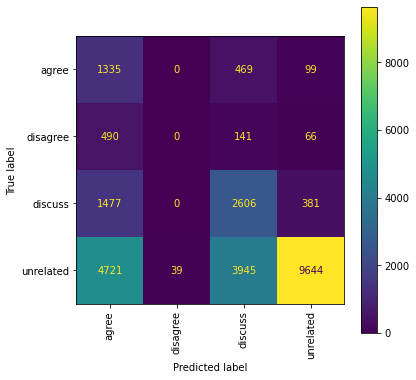

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_labels, pred_labels, xticks_rotation='vertical', ax=ax)
score_test = score_metrics(gold_labels, pred_labels)
print(get_confusion_matrix(gold_labels, pred_labels))

In [ ]:
###########   TEST

test_annot = pd.read_csv("competition_test_stances.csv")
unrelated_num = test_annot.Stance.value_counts().unrelated
unrelated_num = sum(map(lambda x : x == 'unrelated', gold_labels))
max_score = len(test_annot) - (unrelated_num * 0.75)
print(f'Score test: {score_test}/{max_score}, so {(score_test*100)/max_score}%')
print()

Score test: 6996.25/11651.25, so 60.047205235489756%



In [ ]:
f1_summary = f1_score(gold_labels, pred_labels, average=None)
f1_micro = f1_score(gold_labels, pred_labels, average="micro")
f1_macro = f1_score(gold_labels, pred_labels, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

[0.26899053 0.         0.44834409 0.67584709]
0.5345689214181718
0.3482954255965092


In [ ]:
MODEL_TO_LOAD = MODEL_DIR + "cnn_model/seq_length_5.h5"   #CNN experiments/cnn_net_3_layers_2048.h5" #  cnn_net_3_layers_2048 cnn_net_window_5
model_loaded = tf.keras.models.load_model((MODEL_TO_LOAD), custom_objects={'KerasLayer':hub.KerasLayer, 'f1_training':f1_training, 'recall_training':recall_training, 'precision_training':precision_training,})

Inference time: 1643631176.1254628
[[2507, 72, 165, 198], [401, 167, 39, 65], [31, 10, 6735, 351], [320, 5, 646, 28265]]
Score test: 16654.75/18050.0, so 92.27008310249307%

[0.80857926 0.36069114 0.91557912 0.97272649]
0.9423918753283138
0.7643940039458395


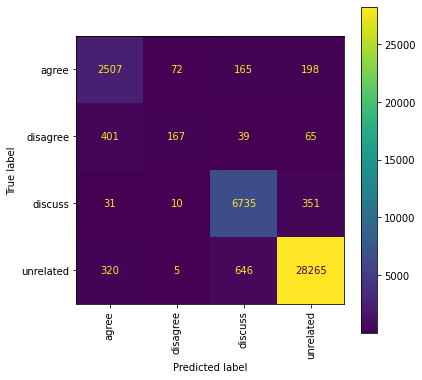

In [ ]:
###########   TRAINING

# compute score on validation
headline_train, body_train, labels_train, headline_val, body_val, labels_val = get_dataset_splitted()

BERT = False

if BERT:
  start_time = time.time()
  pred_labels = get_predictions(headline_train, body_train, model_loaded)
  inference_time = time.time() - start_time
else:
  vectorizer = get_vectorizer(SEQ_LENGTH)
  vect_head_train = vectorizer(np.array([[s] for s in headline_train])).numpy()
  vect_body_train = vectorizer(np.array([[s] for s in body_train])).numpy()

  start_time = time.time()
  pred_labels = get_predictions(vect_head_train, vect_body_train, model_loaded)
  inference_time = time.time()

gold_labels = np.array([LABELS[i] for i in labels_train])
print(f'Inference time: {inference_time}')


fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_labels, pred_labels, xticks_rotation='vertical', ax=ax)
score_test = score_metrics(gold_labels, pred_labels)
print(get_confusion_matrix(gold_labels, pred_labels))


unrelated_num = sum(map(lambda x : x == 3, labels_train))
max_score = len(labels_train) - (unrelated_num * 0.75)
print(f'Score test: {score_test}/{max_score}, so {(score_test*100)/max_score}%')
print()

f1_summary = f1_score(gold_labels, pred_labels, average=None)
f1_micro = f1_score(gold_labels, pred_labels, average="micro")
f1_macro = f1_score(gold_labels, pred_labels, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

Inference time: 1643631135.8375232
[[579, 34, 63, 60], [113, 31, 11, 13], [11, 6, 1626, 139], [116, 2, 253, 6938]]
Score test: 4030.0/4513.25, so 89.29263834265772%

[0.74469453 0.25726141 0.87068273 0.95967909]
0.9178589294647324
0.7080794420202039


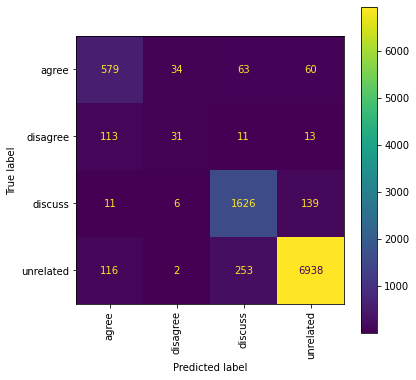

In [ ]:
###########   VALIDATION

# compute score on validation
headline_train, body_train, labels_train, headline_val, body_val, labels_val = get_dataset_splitted()

BERT = False

if BERT:
  start_time = time.time()
  pred_labels = get_predictions(headline_val, body_val, model_loaded)
  inference_time = time.time() - start_time
else:
  vectorizer = get_vectorizer(SEQ_LENGTH)
  vect_head_val = vectorizer(np.array([[s] for s in headline_val])).numpy()
  vect_body_val = vectorizer(np.array([[s] for s in body_val])).numpy()

  start_time = time.time()
  pred_labels = get_predictions(vect_head_val, vect_body_val, model_loaded)
  inference_time = time.time()

gold_labels = np.array([LABELS[i] for i in labels_val])
print(f'Inference time: {inference_time}')


fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(gold_labels, pred_labels, xticks_rotation='vertical', ax=ax)
score_test = score_metrics(gold_labels, pred_labels)
print(get_confusion_matrix(gold_labels, pred_labels))


unrelated_num = sum(map(lambda x : x == 3, labels_val))
max_score = len(labels_val) - (unrelated_num * 0.75)
print(f'Score test: {score_test}/{max_score}, so {(score_test*100)/max_score}%')
print()

f1_summary = f1_score(gold_labels, pred_labels, average=None)
f1_micro = f1_score(gold_labels, pred_labels, average="micro")
f1_macro = f1_score(gold_labels, pred_labels, average="macro")
print(f1_summary)
print(f1_micro)
print(f1_macro)

In [ ]:
headline_train, body_train, labels_train, headline_val, body_val, labels_val = get_dataset_splitted()

In [ ]:
print(labels_val)

[2 3 2 ... 3 3 2]


## **TEST**

In [ ]:
###########   VAL
unrelated_num = sum(map(lambda x : x == 3, labels_val))
print(unrelated_num/len(labels_val))

agree = sum(map(lambda x : x == 0, labels_val)) # 7.4, 1.7, 17.8 73.1
print(agree/len(labels_val)) 

disagree = sum(map(lambda x : x == 1, labels_val))
print(disagree/len(labels_val))

discuss = sum(map(lambda x : x == 2, labels_val))
print(discuss/len(labels_val))

0.7312656328164082
0.07363681840920461
0.01680840420210105
0.17828914457228615


In [ ]:
preprocessing_layer = hub.KerasLayer(BERT_PREPROCESS_MODEL, name='preprocessing')
encoder = hub.KerasLayer(BERT_MODEL, trainable=False, name='BERT_encoder')

In [ ]:
text_test = ['NLP is such an amazing topic!', 'yessss man that\'s right']
text_preprocessed = preprocessing_layer(text_test)
encoder_output = encoder(text_preprocessed)

print(f'Encoder Outputs Len:{len(encoder_output["encoder_outputs"])}')
print(f'First encoder output Shape:{encoder_output["encoder_outputs"][0].shape}')
print(f'First encoder output Values:{encoder_output["encoder_outputs"][0][0, :12]}')

print(f'Last encoder output Shape:{encoder_output["encoder_outputs"][-1].shape}')
print(f'Last encoder output Values:{encoder_output["encoder_outputs"][-1][0, :12]}')

con = layers.Concatenate(axis=2)(encoder_output["encoder_outputs"][-4:])
print(con.shape)

Encoder Outputs Len:12
First encoder output Shape:(2, 128, 768)
First encoder output Values:[[ 0.63196665  0.72824425  0.02815381 ...  0.40477645 -0.27801156
   0.01448902]
 [ 0.19626704 -0.08015473  1.0844378  ... -0.24407747  0.0690643
   1.4097763 ]
 [-0.5235941   0.9797519   0.7515236  ... -0.47939897 -0.2512071
   1.2809124 ]
 ...
 [ 0.4516008  -1.3139483  -0.6335703  ...  0.076499   -0.57104117
  -0.3675774 ]
 [ 0.05883533 -0.25499856 -0.05418177 ...  0.4626816  -0.5195377
   0.46779627]
 [-0.2553115  -0.07954732  0.316671   ...  0.51137197  0.0100887
   0.22091766]]
Last encoder output Shape:(2, 128, 768)
Last encoder output Values:[[-0.33739993 -1.1926047   1.9643435  ...  0.70534587 -0.7244281
   1.4115175 ]
 [-0.4174343  -1.3315657   1.9003549  ...  0.5480451  -0.7924222
   1.8019047 ]
 [-0.4441178  -1.3127457   1.9798666  ...  0.5427514  -0.7651248
   1.8425766 ]
 ...
 [-1.5991316  -0.6604965  -0.13147555 ...  0.6915815  -0.8395759
   1.68677   ]
 [-1.9298526  -0.46980605  0